

## Milestone 3: Adjusted Project Plan and Set Goals


**Project 57**<br/>
**Due: November 13, 2023**<br/>
**Team**: Hannah Boen, Gabe LeBlanc, Ethan Tran

---

#### Resources
- BRFSS dataset from proposal: https://www.cdc.gov/brfss/annual_data/annual_data.htm
- Referenced codebooks from link above
- BRFSS files in accessible csv format: https://osf.io/6rxf4/
- Used 2017-2021 data from link above

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
from datetime import datetime
import seaborn as sns

### About the BRFSS (From the BRFSS Overview 2022)

The **Behavioral Risk Factor Surveillance Survey**, or BRFSS, is a project by the **Center for Disease Control and Prevention** (CDC) that consists of ongoing health-related *telephone surveys*. The BRFSS collects data on risk behaviors, chronic health conditions, healthcare access, and use of preventative servies among noninstitutionalized adults ($\geq$ 18 years). This information is used by state governments to identify demographic variations in health-related behaviors and creating public health programs.

### Problem Statement

Mental health is an increasingly important public health concern throughout the world. It is important then, to identify the determinants of mental health. To that end, we will use data from the BRFSS from 2017 to 2021 to identify important demographic factors that predict the mental health of adults in the United States. We will select predictors from a set of broad categories: sex, education, income, race, statuses (employment, property ownership, etc.), geography to predict the number of days out of thirty that an individual struggles with stress, depression, and problems with emotions. This is measured in the BRFSS as the response variable *MENTHLTH*. Using a predictive model, likely a linear regression, we will predict *MENTHLTH* with predictors from these six clusters.

## <div class='exercise'><b> Data Wrangling</b></div>


#### Cleaning Prototype (2017 Data)

In [2]:
# Example with 2017
df = pd.read_csv("data/BRFSS2017.csv", low_memory=False)
print(df.shape)

(450016, 358)


In [3]:
# print out all columns that have missing values
cols_with_missingness = df.isna().sum()
print(cols_with_missingness[cols_with_missingness > 0])

ctelenm1    252560
pvtresd1    252560
colghous    449975
statere1    252560
cellfon4    252560
             ...  
pavig21_    162062
pa1vigm_    155153
_flshot6    287398
_pneumo2    287398
_aidtst3     41672
Length: 285, dtype: int64


In [4]:
# there are many columns with missingness! if so many values for a column are missing, 
# prediction will be very inaccurate so let's drop those rows

# thresh says keep all columns with at least 400,000 non-NA rows
df_2 = df.dropna(axis=1, thresh=400000)
print(df_2.shape)
cols_with_missingness_2 = df_2.isna().sum()
print(cols_with_missingness_2[cols_with_missingness_2 > 0])

(450016, 151)
genhlth         3
physhlth        1
menthlth        1
hlthpln1        1
persdoc2        3
            ...  
vegeda2_    37252
_frutsu1    39357
_vegesu1    47460
strfreq_    41439
_aidtst3    41672
Length: 78, dtype: int64


In [5]:
# For the rest, we can imput the mean
# Can change this to incorporate training and testing data later
df_clean = df_2.copy()
for column in df_clean.columns:
    df_clean[column] = df_2[column].fillna(df_2[column].mean())

# Check if there are any missing values, there should be none!
# df_2017_clean becomes the variable we use going forward
cols_with_missingness_3 = df_clean.isna().sum()
print(cols_with_missingness_3[cols_with_missingness_3 > 0])

Series([], dtype: int64)


#### Data cleaning function (combines above code)

In [6]:
def clean_data(year):
    df = pd.read_csv(f"data/BRFSS{year}.csv", low_memory=False)
    vars = list(df.columns.values)

    df_2 = df.dropna(axis=1, thresh=400000)
    cols_with_missingness_2 = df_2.isna().sum()

    df_clean = df_2.copy()
    for column in df_clean.columns:
        df_clean[column] = df_2[column].fillna(df_2[column].mean())
        # add a column indicating missingness
        df_clean[column + "_miss"] = df_2[column].isna() * 1

    return df_clean

### Notes on Data Missingness and Cleaning

Ultimately, we may decide **not** to drop as many variables as we do here, since some questions have low response rates because they are tied to other, more specific questions and were thus only asked to specific individuals. As such, missingness may be significant (not at random), which we also capture in the missingness columns added in this block.

We'll also want to be careful about just imputing the mean, since some variables have arbitrary value choices (i.e. a '9' representing a refusal to answer)and others are ordinal or categorical, so we'll take a closer look at which variables imputation would be appropriate for.

As of now, we at least have a complete and smaller dataset to work with, and for the next milestone we'll continue adjusting the methods described above. 

### Milestone 3 Updated Cleaning Function
Instead of dropping based on an arbitrary number of missing values, we'll restrict our dataset to a subset of the overall predictors that we believe would be most relevant to predicting mental health outcomes.

In [7]:
def clean_data_m3(year):

    predictors = []
    predictors.append("sex" if year == 2017 else "sex1" if year == 2018 else "sexvar") 
    predictors.append("_race_g1" if year in [2017, 2018, 2019] else "_raceprv") 
    predictors.append("_cprace1" if year == 2021 else "_cprace")
    predictors.append("income3" if year == 2021 else "income2")
    predictors.append("_incomg1" if year == 2021 else "_incomg") 
    predictors += ["_imprace", "educa", "_educag", "employ1", "_state", "_chispnc", "_crace1"]
    predictors += ["_prace1", "_mrace1", "_race", "_raceg21", "_racegr3", "renthom1", "veteran3", "mscode"]

    predictors += ["colgsex", "landsex", "cellsex"]
    
    orig_df = pd.read_csv(f"data/BRFSS{year}.csv", low_memory=False)

    if year not in [2019, 2020, 2021]:
        orig_df = orig_df.assign(colgsex="NaN")
        orig_df = orig_df.assign(landsex="NaN")
        orig_df = orig_df.assign(cellsex="NaN")
        
    return orig_df[predictors]
    

In [8]:
#Clean years of interest and rename columns for easy interpretation
warnings.filterwarnings("ignore", category=UserWarning)

years = [2017, 2018, 2019, 2020, 2021]
cleaned_dfs = []

for year in years:
    print(year)
    cleaned_df = clean_data_m3(year)
    cleaned_df["year"] = year

    if "_cprace1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"_cprace1": "_cprace"})

    if "income3" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"income3": "income2"})

    if "_race_g1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"_race_g1": "_raceprv"})

    if "_incomg1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"_incomg1": "_incomg"})

    if "sex1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"sex1": "sex"})

    if "sexvar" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"sexvar": "sex"})
    
    if "income2" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"income2": "household_income"})

    if "educa" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"educa": "education"})

    if "_imprace" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"_imprace": "imputed_race"})

    if "employ1" in cleaned_df:
        cleaned_df = cleaned_df.rename(columns={"employ1": "employment"})

    cleaned_dfs.append(cleaned_df)
    
#Concatenate for one large df, keeping only variables consistent throughout all years of interest
common_columns = set(cleaned_dfs[0].columns)
for df in cleaned_dfs[1:]:
    common_columns = common_columns.intersection(df.columns)
final_df = pd.concat([df[list(common_columns)] for df in cleaned_dfs], axis=0, ignore_index=True)
# final_df.set_index("year", inplace=True)

2017


2018
2019
2020
2021


In [9]:
print(final_df.shape)
final_df.head()

(2146371, 24)


,_state,_cprace,_race,_incomg,_raceprv,_racegr3,_raceg21,sex,education,_chispnc,...,veteran3,employment,landsex,_crace1,cellsex,renthom1,_prace1,mscode,household_income,_mrace1
0,1,NaN,1.0,4,1.0,1.0,1.0,2,6.0,NaN,...,1.0,7.0,NaN,NaN,NaN,1.0,1.0,1.0,6.0,1.0
1,1,NaN,1.0,5,1.0,1.0,1.0,1,6.0,NaN,...,2.0,7.0,NaN,NaN,NaN,1.0,1.0,3.0,8.0,1.0
2,1,NaN,1.0,9,1.0,1.0,1.0,1,2.0,NaN,...,2.0,7.0,NaN,NaN,NaN,1.0,1.0,3.0,99.0,1.0
3,1,NaN,1.0,1,1.0,1.0,1.0,2,3.0,NaN,...,2.0,7.0,NaN,NaN,NaN,1.0,1.0,2.0,1.0,1.0
4,1,NaN,1.0,1,1.0,1.0,1.0,2,2.0,NaN,...,2.0,8.0,NaN,NaN,NaN,2.0,1.0,1.0,2.0,1.0


In [10]:
final_df.tail()

,_state,_cprace,_race,_incomg,_raceprv,_racegr3,_raceg21,sex,education,_chispnc,...,veteran3,employment,landsex,_crace1,cellsex,renthom1,_prace1,mscode,household_income,_mrace1
2146366,78,99.0,9.0,3,2.0,9.0,9.0,2,4.0,2.0,...,2.0,1.0,NaN,99.0,2.0,1.0,99.0,NaN,5.0,99.0
2146367,78,NaN,6.0,1,6.0,3.0,2.0,1,4.0,9.0,...,2.0,8.0,NaN,NaN,1.0,1.0,6.0,NaN,1.0,6.0
2146368,78,NaN,2.0,6,2.0,2.0,2.0,1,6.0,9.0,...,2.0,7.0,NaN,NaN,1.0,1.0,2.0,NaN,10.0,2.0
2146369,78,NaN,9.0,4,2.0,9.0,9.0,1,4.0,9.0,...,2.0,7.0,NaN,NaN,1.0,1.0,99.0,NaN,6.0,99.0
2146370,78,NaN,2.0,4,2.0,2.0,2.0,2,6.0,9.0,...,2.0,1.0,NaN,NaN,2.0,1.0,2.0,NaN,6.0,2.0


In [11]:
final_df.columns

Index(['_state', '_cprace', '_race', '_incomg', '_raceprv', '_racegr3',
       '_raceg21', 'sex', 'education', '_chispnc', 'imputed_race', 'year',
       '_educag', 'colgsex', 'veteran3', 'employment', 'landsex', '_crace1',
       'cellsex', 'renthom1', '_prace1', 'mscode', 'household_income',
       '_mrace1'],
      dtype='object')

We'll want to do a pairplot to determine the relationship between these predictors, but there are so many predictors that using all of them may not be feasible. At the same time, some predictors are clearly related, so we grouped related variables together (see our submission document) given that we would expect them to be collinear anyway, choosing only one primary predictor for each category.

In [12]:
primary_predictors = ["sex", "education", "imputed_race", "household_income", "employment", "_state"]

### Editing Data Types

There are a few variables within the data set that are stored in numeric formats that may be better stored in another data type. For example, the variables storing the date of an interview are nominal categorical variables stored as a numeric variable. They will be better as Python *datetime* objects.  

In [15]:
# Example of converting from numeric to date time

# Subset clean_df (not yet cut down to 24 predictors)
clean_df_subset = df_clean.head(50).copy()

# Convert 'idate' into date time object
clean_df_subset['idate'] = pd.to_datetime(clean_df_subset['idate'], format= "%m%d%Y")

# Show converted idate column
clean_df_subset['idate'].head()

0   2017-01-30
1   2017-11-02
2   2017-01-10
3   2017-02-08
4   2017-01-30
Name: idate, dtype: datetime64[ns]

### (To-Do) Handling Ordinality in Nominal Categorical Variables 

## <div class='exercise'><b>Exploratory Data Analysis</b></div>

## Collinearity Matrix

c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

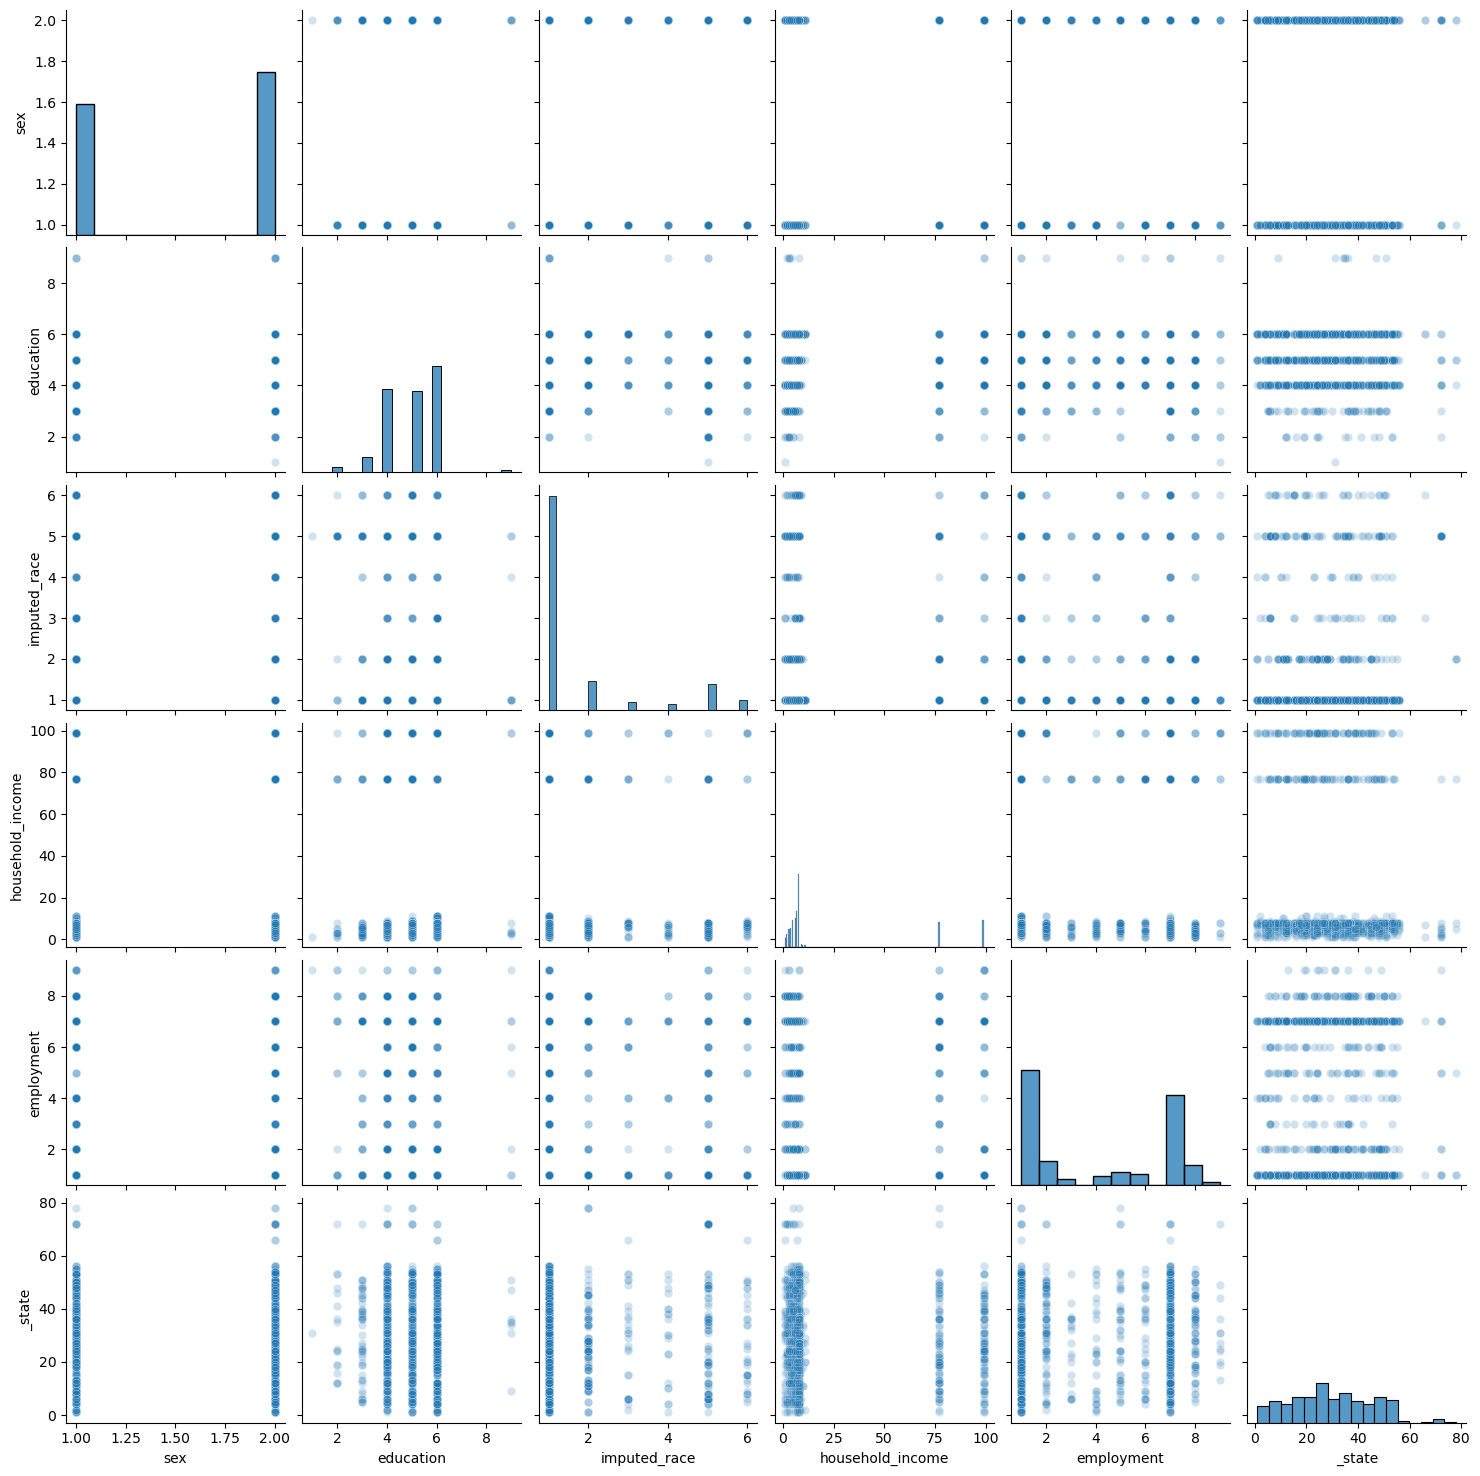

In [16]:
sns.pairplot(final_df[primary_predictors].sample(1000), plot_kws={'alpha':0.2});

It is difficult to identify any clear correlation among predictors, which may mean each predictor is significant enough to be considered. 

One potential issue involves treating categorical values as ordinal (for instance, treating race as ordered integers), so we'll have to be cautious about identifying any linear relationships and potentially readjust our predictor values as well. 

## Correlation Matrix

<Axes: >

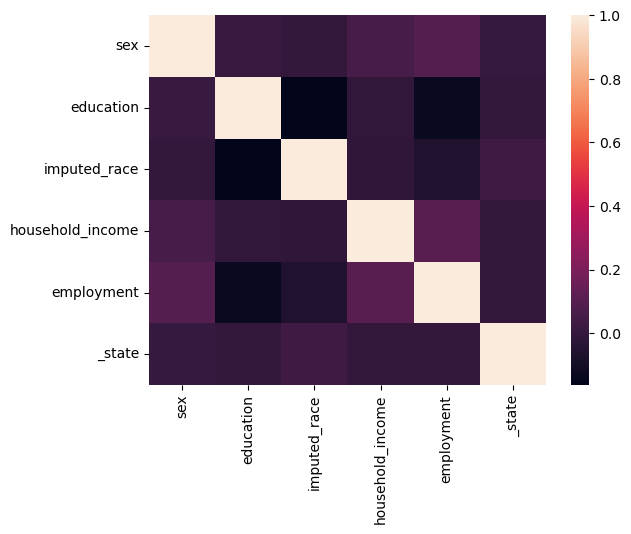

In [17]:
sns.heatmap(final_df[primary_predictors].corr())

We confirm here that our primary variables have very little correlation, so our models should avoid collinearity using these predictors. 

We can also confirm here that our subpredictors are correlateed with our primary predictors:

<Axes: >

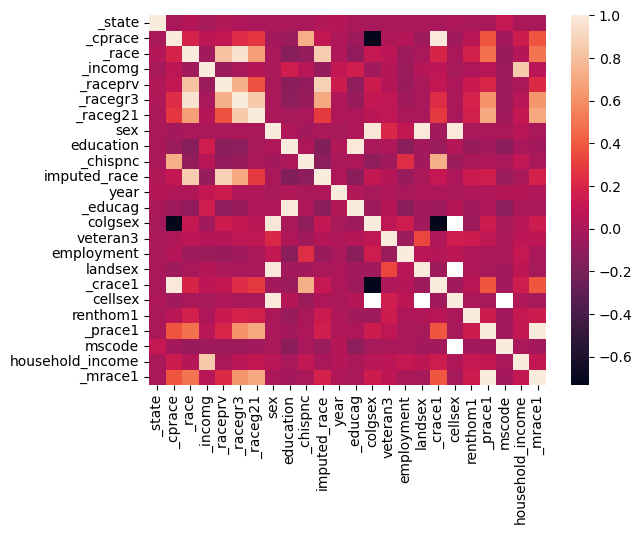

In [18]:
sns.heatmap(final_df.corr())

For instance, education is correlation with _educag (a subpredictor of education), race predictors are often correlated (i.e. _crace1 and _cprace), and sex predictors are correlated too (i.e. colgsex, a subpredictor of sex).

#### Identifying Variables of Interest

In [19]:
#Potential variables of interest
variables = ["sex", "education", "imputed_race", "household_income", "employment"]
var_df = pd.DataFrame(columns=variables, index=[2017, 2018, 2019, 2020, 2021])

# Iterate through the cleaned_dfs and check if each variable is present
for year, cleaned_df in zip([2017, 2018, 2019, 2020, 2021], cleaned_dfs):
    for variable in variables:
        if variable in cleaned_df.columns:
            var_df.at[year, variable] = True
        else:
            var_df.at[year, variable] = False

# Convert data to boolean type
var_df = var_df.astype(bool)
var_df

,sex,education,imputed_race,household_income,employment
2017,True,True,True,True,True
2018,True,True,True,True,True
2019,True,True,True,True,True
2020,True,True,True,True,True
2021,True,True,True,True,True


We identified variables of interest based on variables that likely have large impact on mental health and are represented in all years considered. While some measure of household income and employment is recorded in the 2020 and 2021 datasets, we were unable to locate/rename them in an easily accessible manner that matches the other datasets. There are likely also other variables of interest to explore as a next step.

#### Visualizations for Certain Variables of Interest

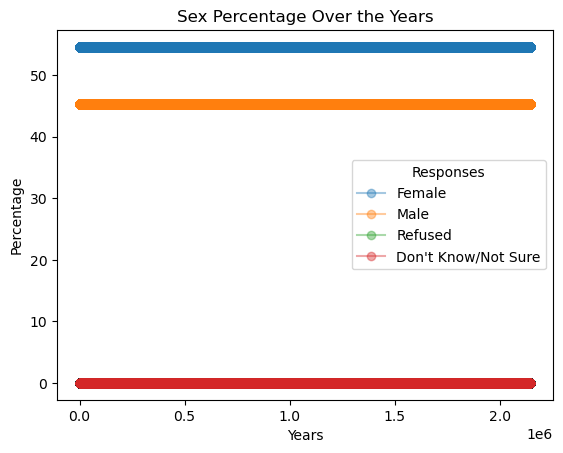

In [20]:
# Get unique responses in the "sex" column
sex_unique = final_df["sex"].unique()
sex_total = final_df["sex"].count()
# Create a dictionary to map responses to custom labels
sex_labels = {
    1: "Male",
    2: "Female",
    7:"Don't Know/Not Sure",
    9: "Refused"
}

for response in sex_unique:
    response_count = (final_df["sex"] == response).sum()
    percentage = (response_count / sex_total) * 100
    plt.plot(final_df.index, [percentage] * sex_total, marker='o', alpha=0.4, label=f'{sex_labels.get(response, response)} Percentage')

legend_labels = [f'{sex_labels.get(response, response)}' for response in sex_unique]
plt.legend(legend_labels, title="Responses")

plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title("Sex Percentage Over the Years")
plt.show()

In [21]:
valid_education_values = [1, 2, 3, 4, 5, 6, 9]
filtered_final_df = final_df[final_df["education"].isin(valid_education_values)]

def round_to_nearest_valid(value):
    return min(valid_education_values, key=lambda x: abs(x - value))

filtered_final_df.loc[:, "education"] = filtered_final_df["education"].apply(round_to_nearest_valid)

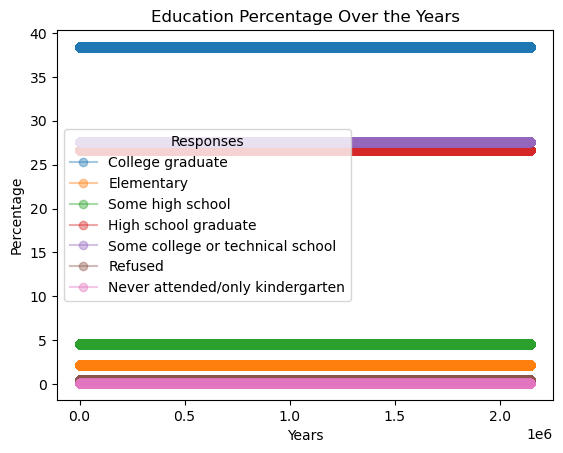

In [22]:
education_unique = filtered_final_df["education"].unique()
education_total = filtered_final_df["education"].count()
education_labels = {
    1: "Never attended/only kindergarten",
    2: "Elementary",
    3: "Some high school",
    4: "High school graduate",
    5: "Some college or technical school",
    6: "College graduate",
    9: "Refused"
}

for response in education_unique:
    response_count = (filtered_final_df["education"] == response).sum()
    percentage = (response_count / education_total) * 100
    plt.plot(filtered_final_df.index, [percentage] * education_total, marker='o', alpha=0.4, label=f'{education_labels.get(response, response)} Percentage')

legend_labels = [f'{education_labels.get(response, response)}' for response in education_unique]
plt.legend(legend_labels, title="Responses", fontsize=10)

plt.xlabel("Years")
plt.ylabel("Percentage")
plt.title("Education Percentage Over the Years")
plt.show()

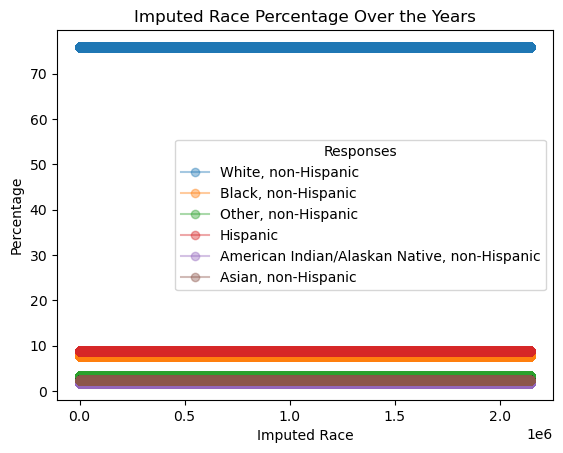

In [23]:
imputed_race_unique = final_df["imputed_race"].unique()
imputed_race_total = final_df["imputed_race"].count()
imputed_race_labels = {
    1: "White, non-Hispanic",
    2: "Black, non-Hispanic",
    3: "Asian, non-Hispanic",
    4: "American Indian/Alaskan Native, non-Hispanic",
    5: "Hispanic",
    6: "Other, non-Hispanic"
}

for response in imputed_race_unique:
    response_count = (final_df["imputed_race"] == response).sum()
    percentage = (response_count / imputed_race_total) * 100
    plt.plot(final_df.index, [percentage] * imputed_race_total, marker='o', alpha=0.4, label=f'{imputed_race_labels.get(response, response)} Percentage')

legend_labels = [f'{imputed_race_labels.get(response, response)}' for response in imputed_race_unique]
plt.legend(legend_labels, title="Responses")

plt.xlabel("Imputed Race")
plt.ylabel("Percentage")
plt.title("Imputed Race Percentage Over the Years")
plt.show()

### Notes on Data Imbalances and Resampling

We see that there are certain absolute and/or simple majorities present in each explored variable of interest. Females are the absolute majority sex, college graduates are the simple majority education level, and whites (non-Hispanics) are the absolute majority imputed race. While it is possible to resample the data and create a balanced dataset, we decided not to resample the data at this time in order to maintain the representativeness and interpretability of the dataset.

For example, there is a slightly larger percentage of females than males in the USA and the US Census Bureau estimated that the USA was ~75% white in 2022 which aligns with the percentages on our graphs. The aim is to reflect real-world demographics and ensure that our findings are applicable to broader populations. By not artificially balancing the data, we preserve the natural variations in demographic factors. We will instead address these imbalances by ensuring that each class is adequately represented in both training and testing sets. 

The line graphs depicting percentages of sex, education, and imputed race variables of interest consistently show similar patterns over the five-year period, appearing as horizontal lines for each response. The stability in these percentages raises questions about potential data calculation errors or variations in data collection methods. Given the relatively short timeframe and minimal reported changes in data collection processes, it is possible that these findings reflect the consistent nature of these demographic attributes throughout the five-year span. This is something we will further analyze in future work.


### Notes on Data Scaling and Weighing

The BRFSS uses *data weighing* to make its sample more representative of the adult population of the United States. Its weighing methodology comprises of a **design weight** that compensates for an individuals' probability of selection and a **demographic adjustment** to weight under-or-over sampled populations towards their true population proportion/importance with iterative proportional fitting or raking. Each year contains new weights calculated for that year's survey, most notably an updated **_LLCPWT** weight for the Combined Land Line and Cell Phone data. This weight contains the required significance scaling for each observation based on their demographics and representation in the sample.


According to a memo accompanying the 2021 BRFSS data, [Complex Sampling Weights and Preparing Module Data for Analysis](https://www.cdc.gov/brfss/annual_data/2021/pdf/Complex-Sampling-Weights-and-Preparing-Module-Data-for-Analysis-2021-508.pdf), "Researchers conducting analysis of variables from the core-only section should use the variable _LLCPWT for weighting" (CDC 2021:2). As our analysis relies primarily on variables generated by questions from the core-only section, we will be utilizing _LLCPWT.

In [24]:
# Weights present in final dataframe
final_df.filter(regex='wt').head()

""
0
1
2
3
4


It seems that **sklearn** has the ability to utilize weights within its models, but we will research the specificities of how to use sampling weights before the next Milestone.

## Missingness

In [37]:
# Subset final df for testing
final_df_subset = final_df.tail(50).copy()

In [38]:
final_df_subset.columns

Index(['_state', '_cprace', '_race', '_incomg', '_raceprv', '_racegr3',
       '_raceg21', 'sex', 'education', '_chispnc', 'imputed_race', 'year',
       '_educag', 'colgsex', 'veteran3', 'employment', 'landsex', '_crace1',
       'cellsex', 'renthom1', '_prace1', 'mscode', 'household_income',
       '_mrace1'],
      dtype='object')

In [98]:
# List of column names for clusters of predictors of interest
sex = ['sex', 'colgsex', 'landsex', 'cellsex']

educ = ['education', '_educag']

income = ['household_income', '_incomg']

race = ['_chispnc', '_cprace', '_prace1', '_mrace1', '_race', '_raceg21', '_racegr3', '_raceprv']

statuses = ['employment', 'renthom1', 'veteran3']

geog = ['_state', 'mscode']

# Names of all clusters as list 
cluster_names = ['sex', 'educ', 'income', 'race', 'statuses', 'geog']

nan_counts = []
for ls in [sex, educ, income, race, statuses, geog]:
    subvar_missing = []
    for subvar in ls:  
        subvar_missing.append(np.sum(final_df[subvar].isna(), axis= 0))
    nan_counts.append(np.sum(subvar_missing))

# Create df with cluster_name and number of NaNs in each cluster
cluster_missingness = pd.DataFrame(cluster_names, columns=['cluster_names'])
cluster_missingness['missing'] = nan_counts


In [99]:
nan_counts

[2745699, 83, 30811, 2489202, 15593, 1408714]

In [100]:
cluster_missingness

,cluster_names,missing
0,sex,2745699
1,educ,83
2,income,30811
3,race,2489202
4,statuses,15593
5,geog,1408714


c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ethan_ipdeobo\.conda\envs\cs109a\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


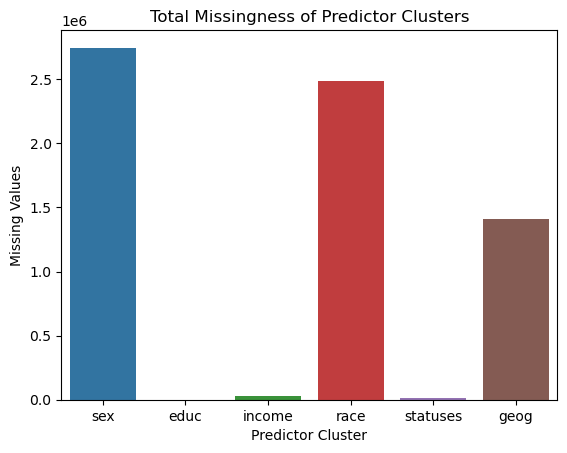

In [101]:
sns.barplot(data=cluster_missingness, x= "cluster_names", y= 'missing').set(xlabel= "Predictor Cluster", ylabel= "Missing Values", title= "Total Missingness of Predictor Clusters");

According to the plot above the sex, race, and geography predictor clusters have the highest number of missing values! This missingness can be explained in part by:


**Sex**
- 'colgsex' and 'landsex' are only collected during landline interviews 
- 'cellsex' is only collected during cellphone interviews


**Race**
- '_chispnc' and '_cprace' indicate if a child is hispanic and a caregiver's preferred race for their child, respectively. They are thus not collected if a respondent is not a parent or guardian 
- Respondents may choose to simply not answer this question or may not even know what to answer


**Geography**
- 'mscode' captures the metropolitan status code for respondents, but does not include data for respondents in Guam, Puerto Rico, the Virgin Islands, and most importantly, respondents using their cell phone


These nuances to the collection of these subvariables within each cluster help account for the high amount of missingness within them.

### Descriptive Statistics

In [113]:
# Grab descriptive statistics for our final dataframe
final_df.describe()

,_state,_cprace,_race,_incomg,_raceprv,_racegr3,_raceg21,sex,education,_chispnc,...,year,_educag,veteran3,employment,_crace1,renthom1,_prace1,mscode,household_income,_mrace1
count,2.146371e+06,302721.000000,2.146366e+06,2.146371e+06,2.120199e+06,2.146366e+06,2.146366e+06,2.146371e+06,2.146288e+06,1.527150e+06,...,2.146371e+06,2.146371e+06,2.141485e+06,2.135757e+06,302721.000000,2.146278e+06,2.146299e+06,737657.000000,2.115560e+06,2.146299e+06
mean,2.977397e+01,8.361620,2.139032e+00,4.870648e+00,1.695500e+00,1.762619e+00,1.409090e+00,1.550487e+00,4.972794e+00,7.660580e+00,...,2.018973e+03,3.006675e+00,1.891893e+00,3.881767e+00,8.210114,1.399892e+00,3.797061e+00,2.946064,2.082179e+01,3.888704e+00
std,1.574623e+01,23.993716,2.382941e+00,2.400193e+00,1.600978e+00,1.628812e+00,1.202356e+00,5.279003e-01,1.059469e+00,2.800525e+00,...,1.430577e+00,1.041836e+00,4.783346e-01,2.876450e+00,23.690792,8.606466e-01,1.456046e+01,1.659845,3.215199e+01,1.456388e+01
min,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,2.017000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00
25%,1.800000e+01,1.000000,1.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,9.000000e+00,...,2.018000e+03,2.000000e+00,2.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000,5.000000e+00,1.000000e+00
50%,2.900000e+01,1.000000,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,9.000000e+00,...,2.019000e+03,3.000000e+00,2.000000e+00,2.000000e+00,1.000000,1.000000e+00,1.000000e+00,3.000000,7.000000e+00,1.000000e+00
75%,4.200000e+01,2.000000,2.000000e+00,5.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,6.000000e+00,9.000000e+00,...,2.020000e+03,4.000000e+00,2.000000e+00,7.000000e+00,2.000000,2.000000e+00,1.000000e+00,5.000000,8.000000e+00,1.000000e+00
max,7.800000e+01,99.000000,9.000000e+00,9.000000e+00,8.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,9.000000e+00,...,2.021000e+03,9.000000e+00,9.000000e+00,9.000000e+00,99.000000,9.000000e+00,9.900000e+01,5.000000,9.900000e+01,9.900000e+01


Unfortunately, all of our predictor variables are categorical. Some are nominal categorical variables such as '_state' for example, and must be handled carefully so as to not imply a hierarchy of categorical classes. Others are ordinal, such as 'year' and 'education' and can safely be used in a linear regression with an interpretable hierarchy to their classes. We will perform releveling to start our categorical variables to have their lowest value be 0 rather than at 1 which is the case for many important predictors such as 'income'. We will also perform a releveling to almost all of our variables to properly handle missingness as many of our variables have multiple categories for a given form of missingness. For example, 'income' has values 1-10 indicating some binned range of incomes, but has value 77 to indicate "Don’t know/Not sure" and value 99 to indicate "Refused" and finally blank (or NaN) to indicate "Not asked or Missing." We will collapse many of these such categories across each predictor cluster into simply NaN for simplicity and clarity.